# **ORATS SPY Options Chain EDA**

This notebook aims to provide additional context on the quality checks implemented in the library, beyond what is covered in the docstrings and code structure.

We load the `qc_summary.json` generated after running the QC pipeline and complement it with exploratory analysis (EDA) to provide a clearer, visual understanding of the results and their practical implications.

The notebook is structured as follows:

1. [Read SPY Options data](#1-read-spy-options-data)
2. [Load QC summary artifact](#2-load-qc-summary-artifact)
3. [GLOBAL vs ROI Interpretation Policy](#3-global-vs-roi-interpretation-policy)
4. [Basic Checks](#4-basic-checks)
5. [Days-to-expiry check](#5-days-to-expiry-check)
6. [Quote sanity checks](#6-quote-sanity-checks)
7. [Volume & Open Interest Checks](#7-volume--open-interest-checks)
8. [Spot price sanity checks](#8-spot-price-sanity-checks)
9. [Dividend Yield checks](#9-dividend-yield-checks)
10.  [Risk-free Rate checks](#10-risk-free-rate-checks)
11.  [Implied Volatility Quality Checks](#11-implied-volatility-quality-checks)
12.  [Greeks Sanity Checks](#12-greeks-sanity-checks)
13.  [Put-call parity diagnostics](#13-put-call-parity-diagnostics)
14.  [Price-bounds diagnostics (calls and puts)](#14-price-bounds-diagnostics-calls-and-puts)
15. [Monotonicity diagnostics](#15-monotonicity-diagnostics)
   - 15.1. [Vertical spread arbitrage (strike monotonicity)](#151-vertical-spread-arbitrage-strike-monotonicity)
   - 15.2. [Calendar arbitrage (maturity monotonicity)](#152-calendar-arbitrage-maturity-monotonicity)
16. [Conclusion](#16-conclusion)

In [10]:
%load_ext autoreload
%autoreload 2

import json
from datetime import date

import pandas as pd
import polars as pl
import yfinance as yf

from volatility_trading.config.paths import PROC_ORATS_OPTIONS_CHAIN
from volatility_trading.datasets import (
    options_chain_wide_to_long,
    read_daily_features,
    scan_options_chain,
)

try:
    from notebooks.qc_eda.helpers import QCSummaryHelper
    from notebooks.qc_eda.plotting import (
        plot_avg_volume_by_delta,
        plot_greeks_vs_strike,
        plot_iv_time_series_with_slope,
        plot_liquidity_by_dte,
        plot_term_structure_samples,
        plot_smiles_by_delta,
        plot_spot_vs_yahoo,
        plot_term_structures_by_delta,
    )
except ModuleNotFoundError:
    from helpers import QCSummaryHelper
    from plotting import (
        plot_avg_volume_by_delta,
        plot_greeks_vs_strike,
        plot_iv_time_series_with_slope,
        plot_liquidity_by_dte,
        plot_term_structure_samples,
        plot_smiles_by_delta,
        plot_spot_vs_yahoo,
        plot_term_structures_by_delta,
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **1. Read SPY Options data & Daily Features**

We analyze the full SPY options chain from `2007-01-01` to `2025-12-31`  keeping
contracts within a broad tradable region.

We also import the **Daily Features** dataset, which contains complementary
metrics used for the analysis over the same period.

In [11]:
TICKER = "SPY"

START = date(2007, 1, 1)
END = date(2025, 12, 5)

DELTA_MIN = 0.01
DELTA_MAX = 0.99
DTE_MIN = 5
DTE_MAX = 252

In [12]:
lf = scan_options_chain(TICKER)
lf = lf.filter(
    pl.col("trade_date").is_between(START, END),
    pl.col("call_delta").abs().is_between(DELTA_MIN, DELTA_MAX),
    pl.col("put_delta").abs().is_between(DELTA_MIN, DELTA_MAX),
    pl.col("dte").is_between(DTE_MIN, DTE_MAX),
)

df = lf.collect()
df_long = options_chain_wide_to_long(df).collect()

df

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,132.0,0,11,1237,18579,9.6,9.7,9.74,9.8,0.020619,0.0,0.05,0.03,0.1,2.0,0.156813,0.09432,0.09613,0.983301,0.008686,-0.025484,0.012315,0.060232,-0.016699,0.008686,-0.025484,0.012315,0.060232,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,133.0,0,70,1921,15443,8.7,8.75,8.77,8.8,0.011429,0.05,0.075,0.06,0.1,0.666667,0.158524,0.08551,0.16521,0.970073,0.014062,-0.029174,0.022321,0.059813,-0.029927,0.014062,-0.029174,0.022321,0.059813,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,134.0,22,0,1447,22032,7.7,7.8,7.8,7.9,0.025641,0.05,0.1,0.09,0.15,1.0,0.155324,0.09083,0.15615,0.955052,0.020038,-0.032558,0.031546,0.059273,-0.044948,0.020038,-0.032558,0.031546,0.059273,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,135.0,63,543,2785,35003,6.7,6.8,6.85,6.9,0.029412,0.1,0.125,0.13,0.15,0.4,0.1511,0.08124,0.14818,0.934797,0.02765,-0.036315,0.037223,0.058383,-0.065203,0.02765,-0.036315,0.037223,0.058383,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,136.0,18,1741,1681,40035,5.8,5.85,5.91,5.9,0.017094,0.15,0.175,0.19,0.2,0.285714,0.145614,0.13073,0.1416,0.908534,0.037099,-0.040146,0.04943,0.0570904,-0.091466,0.037099,-0.040146,0.04943,0.0570904,0.0484,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,850.0,0,0,202,0,0.48,0.49,0.49,0.5,0.040816,163.16,164.63,164.39,166.1,0.017858,0.126529,0.12681,0.12121,0.020504,0.000756,-0.008903,0.265688,0.07697,-0.979496,0.000756,-0.008903,0.265688,0.07697,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,855.0,9,0,50,0,0.42,0.425,0.43,0.43,0.023529,168.15,169.72,169.39,171.29,0.018501,0.127016,0.12735,0.12484,0.017974,0.000673,-0.007968,0.212274,0.067501,-0.982026,0.000673,-0.007968,0.212274,0.067501,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,860.0,0,0,49,0,0.37,0.375,0.37,0.38,0.026667,173.14,174.61,174.39,176.08,0.016838,0.127451,0.12803,0.1259,0.015766,0.000599,-0.007123,0.214644,0.059233,-0.984234,0.000599,-0.007123,0.214644,0.059233,0.036,0.013382


We also import the Daily Features which conatisn useful metrics used for analysis from the sam period

In [13]:
daily_features = read_daily_features(TICKER)
daily_features = daily_features.filter(
    pl.col("trade_date").is_between(START, END)
)
daily_features = daily_features.to_pandas().set_index("trade_date")

daily_features

,ticker,iv_10d,iv_20d,iv_30d,iv_60d,iv_90d,iv_6m,iv_1y,iv_dlt25_10d,iv_dlt25_20d,...,hv_intra_1d,hv_intra_5d,hv_intra_10d,hv_intra_20d,hv_intra_30d,hv_intra_60d,hv_intra_90d,hv_intra_100d,hv_intra_120d,hv_intra_252d
trade_date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,SPY,0.101635,0.102469,0.104870,0.117420,0.124077,0.120905,0.119971,0.091543,0.092130,...,0.1550,0.0966,0.0886,0.0835,0.0884,0.0871,0.1161,0.1138,0.1179,0.1213
2007-01-04,SPY,0.092746,0.094150,0.097141,0.109366,0.122466,0.120715,0.122350,0.085077,0.085406,...,0.0993,0.1002,0.0905,0.0825,0.0899,0.0878,0.1165,0.1138,0.1168,0.1212
2007-01-05,SPY,0.107158,0.107713,0.108645,0.121309,0.121143,0.123434,0.102399,0.095921,0.096610,...,0.1029,0.1042,0.0915,0.0845,0.0913,0.0886,0.1168,0.1141,0.1167,0.1212
2007-01-08,SPY,0.104130,0.104633,0.105134,0.118536,0.119770,0.120721,0.122504,0.093455,0.091858,...,0.0901,0.1093,0.0948,0.0864,0.0926,0.0891,0.1168,0.1140,0.1168,0.1213
2007-01-09,SPY,0.107480,0.107693,0.107879,0.114870,0.126901,0.121019,0.110381,0.101403,0.099474,...,0.0816,0.1088,0.0947,0.0860,0.0934,0.0891,0.1168,0.1135,0.1163,0.1211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-01,SPY,0.131834,0.147691,0.131681,0.144273,0.150576,0.161976,0.170348,0.115265,0.129748,...,0.0738,0.1336,0.1873,0.1658,0.1476,0.1343,0.1247,0.1206,0.1173,0.1930
2025-12-02,SPY,0.132815,0.139302,0.132822,0.143952,0.149011,0.159100,0.166644,0.116351,0.125871,...,0.0652,0.1089,0.1788,0.1654,0.1464,0.1344,0.1248,0.1206,0.1172,0.1930
2025-12-03,SPY,0.126530,0.133172,0.130965,0.142168,0.147754,0.155886,0.169044,0.113659,0.118831,...,0.0800,0.0774,0.1737,0.1635,0.1469,0.1346,0.1250,0.1208,0.1172,0.1930


# **2. Load QC summary results**

The checks below are read from the quality checks summary after running `orats-api-download --config config/orats_api_download.yml`
```

In [14]:
qc_summary_path = (
     PROC_ORATS_OPTIONS_CHAIN / f"underlying={TICKER}" / "qc_summary.json"
)

with qc_summary_path.open(encoding="utf-8") as f:
    qc_summary = json.load(f)

qc_helpers = QCSummaryHelper(qc_summary)

len(qc_summary), qc_summary[3]

(68,
 {'name': 'negative_quotes',
  'severity': 'HARD',
  'grade': 'OK',
  'passed': True,
  'n_rows': 15073890,
  'n_units': None,
  'n_viol': 0,
  'viol_rate': 0.0,
  'details': {}})

# **3. GLOBAL vs ROI Interpretation Policy**

We use this interpretation policy throughout the notebook for every QC family.

- **GLOBAL**: the full options universe after broad filters.
- **ROI**: our practical trading region of interest, roughly:
  - moneyness around **10-90 delta**,
  - maturity around **10-60 DTE**.

Why this split matters:

- Violations in far wings or extreme maturities can be real but less relevant
  to tradable workflows.
- Persistent violations inside ROI are more likely to affect execution quality,
  strategy risk sizing, and signal reliability.

Severity policy used in sections below:

1. **HARD** checks: structural invalid data (drop-candidate rows).
2. **SOFT** checks: investigate rate + location first (GLOBAL vs ROI).
3. **INFO** diagnostics: descriptive metrics, not pass/fail by themselves.

## Liquidity by moneyness: volume by $\Delta$

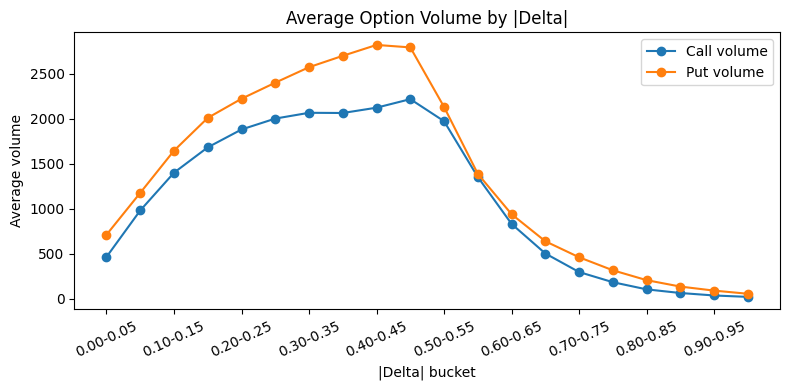

In [15]:
plot_avg_volume_by_delta(df_long)

Deep OTM puts are usually much more traded than symmetric OTM calls, largely
reflecting structural hedging demand.

## Liquidity by maturity: volume/open interest by DTE

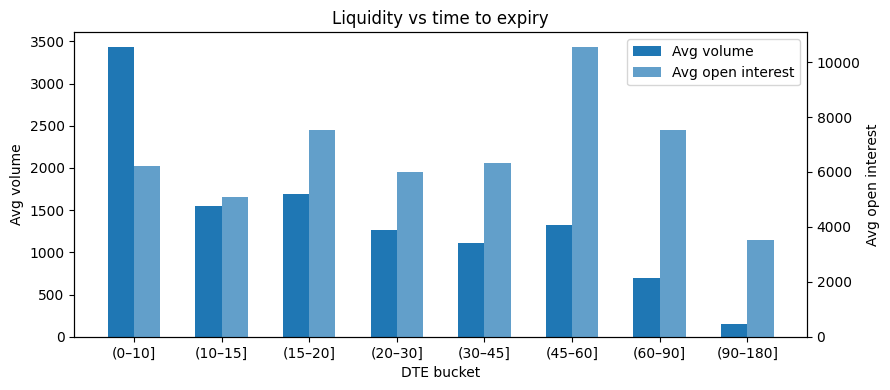

In [16]:
plot_liquidity_by_dte(df_long)

Short maturities often carry higher traded volume relative to open interest,
while longer maturities tend to accumulate open interest with lower turnover.

# **4. Basic Checks**

Hard structural checks + calendar-level dataset checks from the QC summary.

In [17]:
df.describe(percentiles=(0.25, 0.5, 0.75, 0.9))

statistic,ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""5210136""","""5210136""","""5210136""",5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.209951e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210018e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210136e6,5.210097e6
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,0.0,0.0,0.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0
"""mean""",null,"""2019-09-18 16:23:26.956593""","""2019-12-13 23:21:35.402346""",86.290376,0.236412,351.807057,351.807057,338.69139,504.990066,835.606631,3604.081593,6367.606487,25.68974,25.846516,25.807688,26.003291,0.034044,11.943793,12.06081,12.068884,12.177827,0.026395,0.211513,0.211912,0.205559,0.597134,0.013469,-0.073743,0.368623,0.377437,-0.402866,0.013469,-0.073743,0.368623,0.377437,0.019104,0.019355
"""std""",null,null,null,70.964036,0.194422,149.991977,149.991977,149.272448,2934.891553,4246.786983,12448.237324,19997.195595,30.791037,30.963673,30.951292,31.13731,0.096576,17.743193,17.930073,17.93459,18.118407,0.052373,0.094423,0.09628,0.099686,0.323784,0.015228,0.071,0.328258,0.448773,0.323784,0.015228,0.071,0.328258,0.448773,0.020073,0.026415
"""min""","""SPY""","""2007-01-03""","""2007-01-20""",5.0,0.0137,68.11,68.11,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.01,0.000116,-1.401856,0.0,0.0,-0.99,0.000116,-1.401856,0.0,0.0,0.0,0.0
"""25%""",null,"""2017-01-13""","""2017-03-31""",25.0,0.06849,226.66,226.66,216.0,0.0,0.0,21.0,44.0,3.18,3.21,3.21,3.25,0.006956,1.55,1.565,1.58,1.58,0.008306,0.143501,0.14236,0.13912,0.308203,0.004159,-0.098667,0.126952,0.074896,-0.691797,0.004159,-0.098667,0.126952,0.074896,0.001,0.0
"""50%""",null,"""2020-10-16""","""2020-12-31""",64.0,0.17534,344.45,344.45,327.0,5.0,20.0,342.0,609.0,14.61,14.715,14.68,14.81,0.012134,5.4,5.435,5.42,5.48,0.01499,0.194678,0.1936,0.19394,0.697072,0.0084486,-0.052977,0.265509,0.203721,-0.302928,0.0084486,-0.052977,0.265509,0.203721,0.0108,0.0163723
"""75%""",null,"""2023-02-24""","""2023-05-19""",140.0,0.38356,447.5,447.5,442.0,100.0,227.0,2004.0,3472.0,36.12,36.335,36.22,36.55,0.023753,14.81,14.94,14.94,15.06,0.027174,0.25794,0.25949,0.25726,0.886552,0.017199,-0.026323,0.5085364,0.518745,-0.113448,0.017199,-0.026323,0.5085364,0.518745,0.0415,0.025041
"""90%""",null,"""2024-12-20""","""2025-03-21""",200.0,0.54795,572.09,572.09,550.0,713.0,1280.0,7803.0,14721.0,68.68,69.06,69.0,69.44,0.064516,30.43,30.75,30.82,31.07,0.049587,0.327898,0.3324,0.3243,0.955363,0.030165,-0.013881,0.8498171,0.973513,-0.044637,0.030165,-0.013881,0.8498171,0.973513,0.0515,0.0407233


## Hard key integrity checks (non-negotiable)

Policy:
- Keys required to identify one contract observation should never be null.
- Any material violation is a data-integrity blocker.

In [18]:
df.with_columns(qT = pl.col("yte") * pl.col("dividend_yield")).filter(pl.col("qT") > 0.05)

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield,qT
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2009-02-23,2009-09-19,208,0.56986,74.65,74.65,53.0,0,0,11,3404,23.3,23.65,23.46,24.0,0.029598,2.61,2.67,2.73,2.73,0.044944,0.5251,0.53931,0.5206,0.854199,0.007928,-0.025773,0.123532,0.221401,-0.145801,0.007928,-0.025773,0.123532,0.221401,0.0069,0.090736,0.051707
"""SPY""",2009-02-23,2009-09-19,208,0.56986,74.65,74.65,54.0,0,0,10,2913,22.5,22.825,22.7,23.15,0.028478,2.8,2.865,2.92,2.93,0.045375,0.519909,0.52926,0.51589,0.844903,0.008345,-0.02631,0.134302,0.22164,-0.155097,0.008345,-0.02631,0.134302,0.22164,0.0069,0.090736,0.051707
"""SPY""",2009-02-23,2009-09-19,208,0.56986,74.65,74.65,55.0,0,13,10,2854,21.7,22.025,21.94,22.35,0.029512,3.0,3.075,3.12,3.15,0.04878,0.514617,0.52042,0.51126,0.835201,0.008769,-0.026814,0.136164,0.222001,-0.164799,0.008769,-0.026814,0.136164,0.222001,0.0069,0.090736,0.051707
"""SPY""",2009-02-23,2009-09-19,208,0.56986,74.65,74.65,56.0,0,0,10,2569,20.95,21.25,21.19,21.55,0.028235,3.2,3.275,3.33,3.35,0.045802,0.50955,0.51287,0.50576,0.825283,0.009205,-0.027321,0.146526,0.2219,-0.174717,0.009205,-0.027321,0.146526,0.2219,0.0069,0.090736,0.051707
"""SPY""",2009-02-23,2009-09-19,208,0.56986,74.65,74.65,57.0,0,0,10,1700,20.15,20.45,20.46,20.75,0.02934,3.4,3.5,3.56,3.6,0.057143,0.504271,0.50326,0.50061,0.814734,0.009639,-0.027762,0.148531,0.221782,-0.185266,0.009639,-0.027762,0.148531,0.221782,0.0069,0.090736,0.051707
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2009-06-18,2009-12-31,196,0.53699,92.22,92.22,115.0,0,0,1937,2607,0.36,0.415,0.39,0.47,0.26506,24.2,24.55,27.42,24.9,0.028513,0.193885,0.19589,0.0,0.072884,0.010857,-0.006075,0.096302,0.03292,-0.927116,0.010857,-0.006075,0.096302,0.03292,0.0052,0.0984789,0.052882
"""SPY""",2009-06-18,2009-12-31,196,0.53699,92.22,92.22,116.0,0,0,601,1276,0.3,0.35,0.34,0.4,0.285714,25.3,25.575,28.42,25.85,0.021505,0.192602,0.19424,0.0,0.063668,0.009837,-0.005402,0.082143,0.028769,-0.936332,0.009837,-0.005402,0.082143,0.028769,0.0052,0.0984789,0.052882
"""SPY""",2009-06-18,2009-12-31,196,0.53699,92.22,92.22,117.0,0,0,343,2689,0.24,0.29,0.28,0.34,0.344828,26.2,26.525,29.42,26.85,0.024505,0.191292,0.19209,0.0,0.054985,0.008835,-0.004757,0.069639,0.024863,-0.945015,0.008835,-0.004757,0.069639,0.024863,0.0052,0.0984789,0.052882


In [19]:
basic_checks = qc_helpers.qc_table(
    [
        "keys_not_null",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0


## Calendar-level dataset checks (GLOBAL diagnostics)

Policy:
- Missing exchange sessions and non-trading dates are dataset-level diagnostics.
- Small, explainable exceptions are investigated before escalation.

In [20]:
basic_checks = qc_helpers.qc_table(
    [
        "keys_not_null",
        "trade_date_leq_expiry_date",
        "GLOBAL_missing_sessions_xnys",
        "GLOBAL_non_trading_dates_present_xnys",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_missing_sessions_xnys""","""SOFT""","""OK""",true,15073890,4763,0,0.0
"""GLOBAL_non_trading_dates_prese…","""SOFT""","""MILD""",true,15073890,4764,1,0.00021


In [21]:
missing_sessions = qc_helpers.qc_details("GLOBAL_missing_sessions_xnys").get("missing_dates", [])
non_trading = qc_helpers.qc_details("GLOBAL_non_trading_dates_present_xnys").get("extra_dates", [])

print("Missing XNYS sessions:", len(missing_sessions))
print("Non-trading dates present:", len(non_trading))
print("Sample missing sessions:", missing_sessions[:5])
print("Sample non-trading dates:", non_trading[:5])

Missing XNYS sessions: 0
Non-trading dates present: 1
Sample missing sessions: []
Sample non-trading dates: ['2018-12-05']


After investgiation the trading date `2018-12-05` coreesponds to George W bush memorial day where the NYSE was closed but here the options market were still opened.

In [22]:
df.filter(pl.col("trade_date") == pl.date(2018, 12, 5))

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,240.0,0,682,4,1442,30.11,30.47,30.5,30.83,0.02363,0.11,0.115,0.06,0.12,0.086957,0.459215,0.31184,0.50244,0.98811,0.0021333,-0.06793,0.009274,0.032421,-0.01189,0.0021333,-0.06793,0.009274,0.032421,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,245.0,0,1340,14,1356,25.14,25.5,25.57,25.86,0.028235,0.14,0.145,0.13,0.15,0.068966,0.437442,0.27153,0.44393,0.97515,0.004205,-0.10358,0.017665,0.032616,-0.02485,0.004205,-0.10358,0.017665,0.032616,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,246.0,0,41,0,0,24.15,24.505,24.6,24.86,0.028974,0.14,0.145,0.16,0.15,0.068966,0.434821,0.26258,0.42852,0.970862,0.004833,-0.114483,0.021471,0.032591,-0.029138,0.004833,-0.114483,0.021471,0.032591,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,247.0,0,51,0,1,23.15,23.51,23.62,23.87,0.030625,0.15,0.155,0.18,0.16,0.064516,0.428644,0.25504,0.41758,0.96714,0.005421,-0.122714,0.025743,0.0325869,-0.03286,0.005421,-0.122714,0.025743,0.0325869,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,248.0,0,66,0,0,22.16,22.52,22.65,22.88,0.031972,0.15,0.16,0.21,0.17,0.125,0.424085,0.24742,0.40435,0.962074,0.006156,-0.13381,0.025806,0.032532,-0.037926,0.006156,-0.13381,0.025806,0.032532,0.0237,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,320.0,11,0,638,11,0.39,0.43,0.55,0.47,0.186047,49.98,50.695,53.69,51.41,0.028208,0.132639,0.12668,0.0,0.050525,0.003903,-0.007727,0.206732,0.072968,-0.949475,0.003903,-0.007727,0.206732,0.072968,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,325.0,0,0,298,0,0.27,0.305,0.35,0.34,0.229508,54.97,55.685,58.69,56.4,0.02568,0.131278,0.1281,0.0,0.034592,0.002902,-0.005588,0.145047,0.050072,-0.965408,0.002902,-0.005588,0.145047,0.050072,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,330.0,0,0,2510,5,0.2,0.235,0.22,0.27,0.297872,59.96,60.675,63.69,61.39,0.023568,0.130202,0.13111,0.0,0.023325,0.002105,-0.003963,0.121492,0.0338733,-0.976675,0.002105,-0.003963,0.121492,0.0338733,0.0271,0.0


As you can see contracts were traded that day so we keep this day in our backtest.

# **5. Days-to-expiry check**


Here a `HARD` error will be that the current `trade_date` is larger than the exipiry
whihc is imposisble as at the latest the trade_date can match the maturity on the expiry date but beyind it is impossible.

We alos check the distributuon of the `dte` column expecting dte ranging from the tradebale filters we have applied.

In [23]:
dte_checks = qc_helpers.qc_table(["trade_date_leq_expiry_date"])
dte_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0


## 5.2. DTE distribution sanity (INFO diagnostics)

In [24]:
global_dte_stats = qc_helpers.info_stats_metric("GLOBAL_core_numeric_stats", "dte")
print("GLOBAL DTE stats")
display(global_dte_stats)

GLOBAL DTE stats


,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,dte,0.0,15073890,1.0,252.0,67.379465,68.617457,36.0,1.0,1.0,3.0,36.0,217.0,245.0,252.0


# **6. Quote sanity checks**

Here we separate quote checks into 3 groups:

1. **Hard data errors** (drop-candidate rows)
   - `negative_quotes`: bid or ask below zero (impossible market quotes)
   - `crossed_market`: bid above ask (invalid quote state)
   - `bid_ask_sane`: hard guardrail summary for bid/ask consistency

2. **Suspicious but often explainable microstructure cases** (investigate first)
   - `locked_market`: bid equals ask
   - `one_sided_quotes`: no bid with positive ask
   These can happen, especially in low-liquidity wings or near close.

3. **Spread quality diagnostics**
   - `wide_spread` and `very_wide_spread`
   Not always a data error, but a trading-quality warning.
   In practice, we care whether they cluster outside the tradable ROI.

## Hard quote errors (non-negotiable)

In [25]:
hard_quote_checks = qc_helpers.qc_table(
    [
        "bid_ask_sane",
        "negative_quotes",
        "crossed_market",
    ]
)
hard_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""bid_ask_sane""","""HARD""","""OK""",true,15073890,null,0,0.0
"""crossed_market""","""HARD""","""OK""",true,15073890,null,0,0.0
"""negative_quotes""","""HARD""","""OK""",true,15073890,null,0,0.0


## Locked and one-sided quotes (investigate, then decide)

In [26]:
microstructure_quote_checks = qc_helpers.qc_table(
    [
        "GLOBAL_locked_market_C",
        "GLOBAL_locked_market_P",
        "ROI_locked_market_C",
        "ROI_locked_market_P",
        "GLOBAL_one_sided_quotes_C",
        "GLOBAL_one_sided_quotes_P",
        "ROI_one_sided_quotes_C",
        "ROI_one_sided_quotes_P",
    ]
)
microstructure_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_locked_market_C""","""SOFT""","""OK""",true,15073890,null,29788,0.001976
"""GLOBAL_locked_market_P""","""SOFT""","""OK""",true,15073890,null,24731,0.001641
"""GLOBAL_one_sided_quotes_C""","""SOFT""","""WARN""",false,15073890,null,539559,0.035794
"""GLOBAL_one_sided_quotes_P""","""SOFT""","""MILD""",true,15073890,null,204344,0.013556
"""ROI_locked_market_C""","""SOFT""","""OK""",true,2678530,null,63,0.000024
"""ROI_locked_market_P""","""SOFT""","""OK""",true,2678530,null,103,0.000038
"""ROI_one_sided_quotes_C""","""SOFT""","""OK""",true,2678530,null,22,0.000008
"""ROI_one_sided_quotes_P""","""SOFT""","""OK""",true,2678530,null,10,0.000004


In [27]:
qc_helpers.qc_top_buckets("GLOBAL_one_sided_quotes_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(-inf, 0]""",143548,310018,0.463031,0.702482,0.041133
"""(10, 30]""","""(-inf, 0]""",14386,111212,0.129357,0.070401,0.014756
"""(0, 10]""","""(0, 0.05]""",29371,386997,0.075895,0.143733,0.051347
"""(30, 60]""","""(-inf, 0]""",592,21540,0.027484,0.002897,0.002858
"""(30, 60]""","""(0, 0.05]""",5684,251712,0.022581,0.027816,0.033397


In [28]:
qc_helpers.qc_top_buckets("ROI_one_sided_quotes_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(0.3, 0.7]""",5,275072,0.000018,0.5,0.205391
"""(10, 30]""","""(0.1, 0.3]""",2,285255,0.000007,0.2,0.212994
"""(10, 30]""","""(0.7, 0.9]""",1,149096,0.000007,0.1,0.111327
"""(30, 60]""","""(0.1, 0.3]""",1,233854,0.000004,0.1,0.174614
"""(30, 60]""","""(0.3, 0.7]""",1,242656,0.000004,0.1,0.181186


## Spread diagnostics (execution quality)

In [29]:
spread_quote_checks = qc_helpers.qc_table(
    [
        "GLOBAL_wide_spread_C",
        "GLOBAL_wide_spread_P",
        "ROI_wide_spread_C",
        "ROI_wide_spread_P",
        "GLOBAL_very_wide_spread_C",
        "GLOBAL_very_wide_spread_P",
        "ROI_very_wide_spread_C",
        "ROI_very_wide_spread_P",
    ]
)
spread_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_very_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_very_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,149886,0.009943
"""GLOBAL_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,41760,0.00277
"""ROI_very_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_very_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,79,0.000029
"""ROI_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,234,0.000087


In [30]:
qc_helpers.qc_top_buckets("GLOBAL_wide_spread_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(-inf, 0]""",6665,111212,0.059931,0.159602,0.014756
"""(30, 60]""","""(-inf, 0]""",747,21540,0.03468,0.017888,0.002858
"""(0, 10]""","""(-inf, 0]""",9916,310018,0.031985,0.237452,0.041133
"""(30, 60]""","""(0, 0.05]""",7670,251712,0.030471,0.183669,0.033397
"""(10, 30]""","""(0, 0.05]""",9991,393513,0.025389,0.239248,0.052211


In [31]:
qc_helpers.qc_top_buckets("ROI_wide_spread_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.1, 0.3]""",118,233854,0.000505,0.504274,0.174614
"""(10, 30]""","""(0.1, 0.3]""",74,285255,0.000259,0.316239,0.212994
"""(10, 30]""","""(0.3, 0.7]""",21,275072,0.000076,0.089744,0.205391
"""(0, 10]""","""(0.3, 0.7]""",1,13349,0.000075,0.004274,0.009967
"""(0, 10]""","""(0.1, 0.3]""",1,14087,0.000071,0.004274,0.010518


# **7. Volume & Open Interest Checks**

Here we separate volume/OI checks into 3 groups:

1. **Hard data errors** (drop-candidate rows)
   - `negative_vol_oi`: negative traded volume or open interest (invalid values)

2. **Soft consistency diagnostics** (investigate first)
   - `zero_vol_pos_oi`: positive OI with zero volume
   - `pos_vol_zero_oi`: positive volume with zero OI
   These are often explainable by microstructure/timing but can cluster in weak
   quality regions.

3. **INFO liquidity diagnostics**
   - `volume_oi_metrics` summaries for GLOBAL and ROI scopes
   Not a pass/fail rule; used to profile tradability and market depth.

## Hard volume/OI sign errors (non-negotiable)

In [32]:
hard_vol_oi_checks = qc_helpers.qc_table(["negative_vol_oi"])
hard_vol_oi_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""negative_vol_oi""","""HARD""","""OK""",true,15073890,null,0,0.0


## Soft volume/OI mismatch diagnostics

In [33]:
soft_vol_oi_checks = qc_helpers.qc_table(
    [
        "GLOBAL_zero_vol_pos_oi_C",
        "GLOBAL_zero_vol_pos_oi_P",
        "ROI_zero_vol_pos_oi_C",
        "ROI_zero_vol_pos_oi_P",
        "GLOBAL_pos_vol_zero_oi_C",
        "GLOBAL_pos_vol_zero_oi_P",
        "ROI_pos_vol_zero_oi_C",
        "ROI_pos_vol_zero_oi_P",
    ]
)
soft_vol_oi_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,15073890,null,193694,0.01285
"""GLOBAL_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,15073890,null,242990,0.01612
"""GLOBAL_zero_vol_pos_oi_C""","""SOFT""","""MILD""",true,15073890,null,1873603,0.124295
"""GLOBAL_zero_vol_pos_oi_P""","""SOFT""","""MILD""",true,15073890,null,1260351,0.083612
"""ROI_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,2678530,null,73999,0.027627
"""ROI_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,2678530,null,80056,0.029888
"""ROI_zero_vol_pos_oi_C""","""SOFT""","""OK""",true,2678530,null,104126,0.038874
"""ROI_zero_vol_pos_oi_P""","""SOFT""","""OK""",true,2678530,null,51196,0.019113


## INFO liquidity metrics (GLOBAL vs ROI)

In [34]:
vol_oi_metrics = pd.DataFrame(
    [
        qc_helpers.qc_details("GLOBAL_volume_oi_metrics"),
        qc_helpers.qc_details("ROI_volume_oi_metrics"),
    ],
    index=["GLOBAL_volume_oi_metrics", "ROI_volume_oi_metrics"],
)
vol_oi_metrics

,n_rows,volume_null_rate,volume_zero_rate,oi_null_rate,oi_zero_rate
GLOBAL_volume_oi_metrics,15073890,0.0,0.361542,0.0,0.182605
ROI_volume_oi_metrics,2678530,0.0,0.116327,0.0,0.115854


In [35]:
qc_helpers.qc_top_buckets("GLOBAL_zero_vol_pos_oi_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(180, inf]""","""(0.1, 0.3]""",105080,259346,0.405173,0.083374,0.03441
"""(60, 180]""","""(-inf, 0]""",4016,10030,0.400399,0.003186,0.001331
"""(180, inf]""","""(0.7, 0.9]""",36599,93024,0.393436,0.029039,0.012342
"""(180, inf]""","""(0, 0.05]""",8803,22831,0.385572,0.006985,0.003029
"""(180, inf]""","""(0.05, 0.1]""",21604,58636,0.368443,0.017141,0.00778


In [36]:
qc_helpers.qc_top_buckets("GLOBAL_pos_vol_zero_oi_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.3, 0.7]""",21339,242656,0.087939,0.087818,0.032196
"""(0, 10]""","""(0.95, 1]""",34470,459052,0.07509,0.141858,0.060907
"""(30, 60]""","""(0.1, 0.3]""",15410,233854,0.065896,0.063418,0.031028
"""(0, 10]""","""(0.9, 0.95]""",1982,31697,0.06253,0.008157,0.004206
"""(30, 60]""","""(0.7, 0.9]""",6867,118251,0.058071,0.02826,0.01569


# **8. Spot price sanity checks**

We validate spot data in two steps:
8.1. structural consistency checks from the QC summary,
8.2. external cross-check versus Yahoo Finance close (EDA context).

## Structural spot consistency checks (QC summary)

We check that `spot_price` is constant across the chain for each trading day.
For SPY (equity ETF options), `spot_price` is also expected to match
`underlying_price` at the day level.

In [37]:
spot_checks = qc_helpers.qc_table(
    [
        "GLOBAL_spot_constant_per_trade_date",
        "GLOBAL_spot_equals_underlying_per_trade_date",
    ]
)
spot_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""GLOBAL_spot_constant_per_trade…","""SOFT""","""OK""",true,15073890,4764,0,0.0
"""GLOBAL_spot_equals_underlying_…","""SOFT""","""OK""",true,15073890,4764,0,0.0


## ORATS SPY vs Yahoo Finance non-adjusted close

ORATS options snapshots are taken close to end-of-day, so ORATS spot should be
close to a reference close series. We use Yahoo Finance non-adjusted close as
a practical benchmark for SPY.

In [38]:
spx_yf = yf.download(TICKER, start=start, end=end, auto_adjust=False)["Close"]
spx_yf = spx_yf.squeeze()
spx_yf.name = "spy_yf_close"

spx_orats = (
    df.group_by("trade_date")
    .agg(pl.col("spot_price").first().alias("spy_orats_spot"))
    .sort("trade_date")
    .to_pandas()
    .set_index("trade_date")
)

spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()

diff = spx["spy_orats_spot"] - spx["spy_yf_close"]
rel_diff = diff / spx["spy_yf_close"]
corr = spx.corr().loc["spy_yf_close", "spy_orats_spot"]

print("Correlation (ORATS spot vs Yahoo close):", corr)
display(
    pd.DataFrame({"abs_diff": diff.abs(), "rel_diff": rel_diff}).describe(
        percentiles=[0.5, 0.9, 0.99]
    )
)

[*********************100%***********************]  1 of 1 completed


Correlation (ORATS spot vs Yahoo close): 0.9999912820675189


/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_19975/84948794.py:13: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()


,abs_diff,rel_diff
count,4762.000000,4.762000e+03
mean,0.299533,2.114660e-05
std,0.543123,1.775585e-03
min,0.000000,-2.775000e-02
50%,0.100007,-2.772942e-09
90%,0.830002,1.340869e-03
99%,2.487791,4.921786e-03
max,7.410001,2.151342e-02


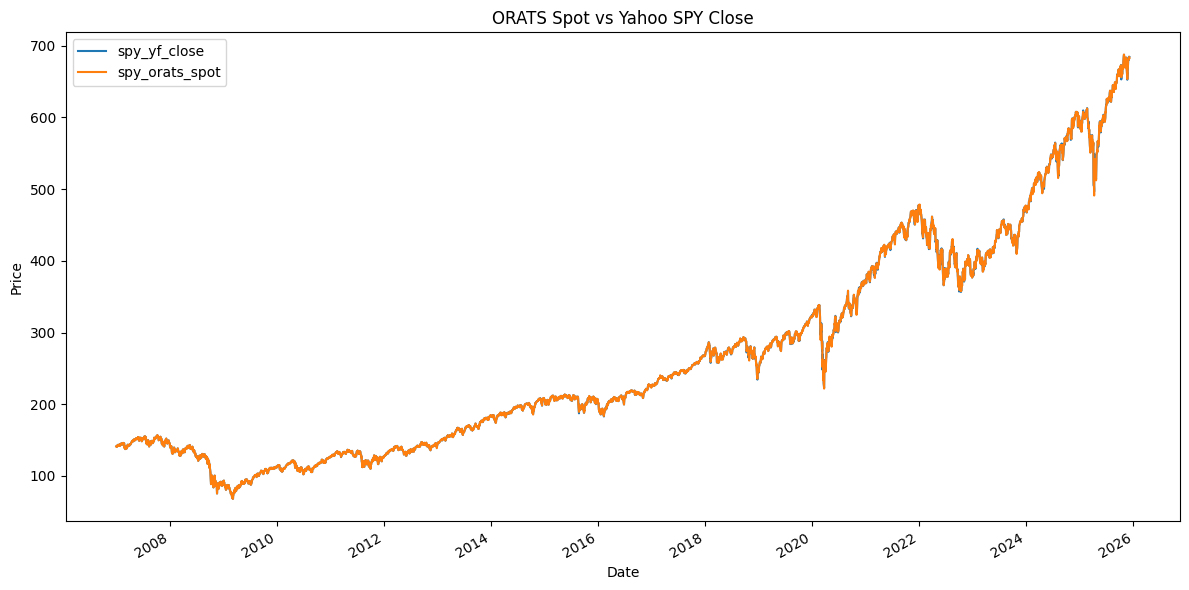

In [39]:
plot_spot_vs_yahoo(spx)

ORATS spot and Yahoo close are very close in level and correlation, which
supports the quality of ORATS spot inputs for downstream diagnostics.

# **9. Dividend Yield checks**

Dividend yield enters several model-based diagnostics (notably parity bounds
through the carry term `qT`). We first inspect summary stats, then inspect the
cross-DTE shape on sample days.

In [40]:
qc_helpers.info_stats_metric("GLOBAL_core_numeric_stats", "dividend_yield")

,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,dividend_yield,0.000846,15061138,0.0,0.98337,0.020372,0.04519,0.012595,0.0,0.0,0.0,0.012595,0.072937,0.187362,0.98337


In [41]:
qc_helpers.info_stats_metric("ROI_core_numeric_stats", "dividend_yield")

,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,dividend_yield,0.0,2678530,0.0,0.568204,0.019147,0.031293,0.0,0.0,0.0,0.0,0.0,0.080451,0.131615,0.568204


Typical levels (mean/median near ~2%) are plausible for SPY, while the upper
tail is large in unconditional stats. The term-structure view below is used to
separate structural ex-dividend effects from true outlier/noise behavior.

## Term-structure of dividend yield

We overlay Yahoo Finance ex-dividend dates as dashed vertical markers in DTE
space for each sample day. This helps check whether sharp jumps in the
`dividend_yield` curve align with upcoming ex-dividend events.

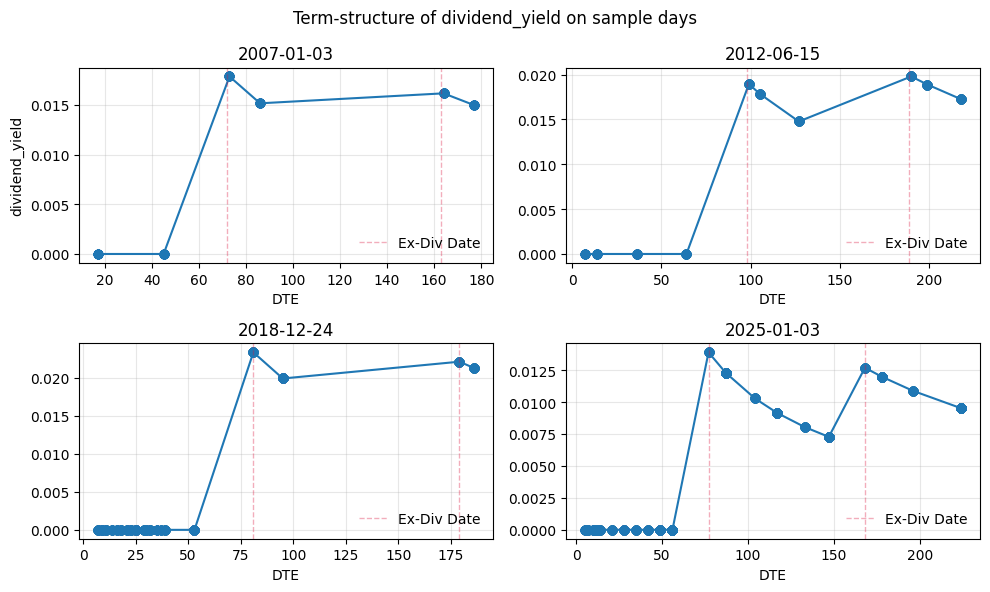

In [42]:
sample_days = [
    date(2007, 1, 3),
    date(2012, 6, 15),
    date(2018, 12, 24),
    date(2025, 1, 3),
]

spy_dividends = yf.Ticker(TICKER).dividends
ex_div_dates = sorted(
    {
        pd.Timestamp(ts).date()
        for ts in spy_dividends.index
        if start <= pd.Timestamp(ts).date() <= end
    }
)

plot_term_structure_samples(
    df,
    sample_days=sample_days,
    value_col="dividend_yield",
    ex_div_dates=ex_div_dates,
)

In these sample days, the main **dividend-yield jumps** align with **ex-dividend
anchors**, which supports a **structural carry** interpretation rather than random
data corruption.

# **10. Risk-free Rate checks**

Risk-free rates drive discounting in price bounds and parity diagnostics, so we
validate both structural consistency and level behavior.

## 10.1. Structural uniqueness check (per day-expiry bucket)

We expect one consistent risk-free rate per `(trade_date, expiry_date)` slice.
In this run, the check passes with `0` violations, which supports internal
consistency of rate assignment.

In [43]:
rf_checks = qc_helpers.qc_table(
    [
        "GLOBAL_unique_risk_free_rate_per_day_expiry",
    ]
)
rf_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""GLOBAL_unique_risk_free_rate_p…","""SOFT""","""OK""",true,15073890,79950,0,0.0


## 10.2. INFO risk-free metrics (GLOBAL vs ROI)

The metrics indicate:
- no missing values (`r_null_rate = 0.0`) in both GLOBAL and ROI,
- plausible range (`r_min = 0.0`, `r_max = 0.0602`),
- similar central levels across scopes (GLOBAL mean/median around `1.97%/1.23%`,
  ROI around `1.85%/1.10%`).

This suggests rates are well-covered and in a realistic magnitude range for the
sample horizon.

In [44]:
pd.DataFrame(
    [
        qc_helpers.qc_details("GLOBAL_risk_free_rate_metrics"),
        qc_helpers.qc_details("ROI_risk_free_rate_metrics"),
    ],
    index=["GLOBAL_risk_free_rate_metrics", "ROI_risk_free_rate_metrics"],
)

,n_rows,r_null_rate,r_min,r_max,r_mean,r_median
GLOBAL_risk_free_rate_metrics,15073890,0.0,0.0,0.0602,0.019690,0.0123
ROI_risk_free_rate_metrics,2678530,0.0,0.0,0.0602,0.018491,0.0110


## Term-structure sanity on sample days

We inspect several dates to verify that cross-DTE rate curves are smooth and
economically coherent across rate regimes.

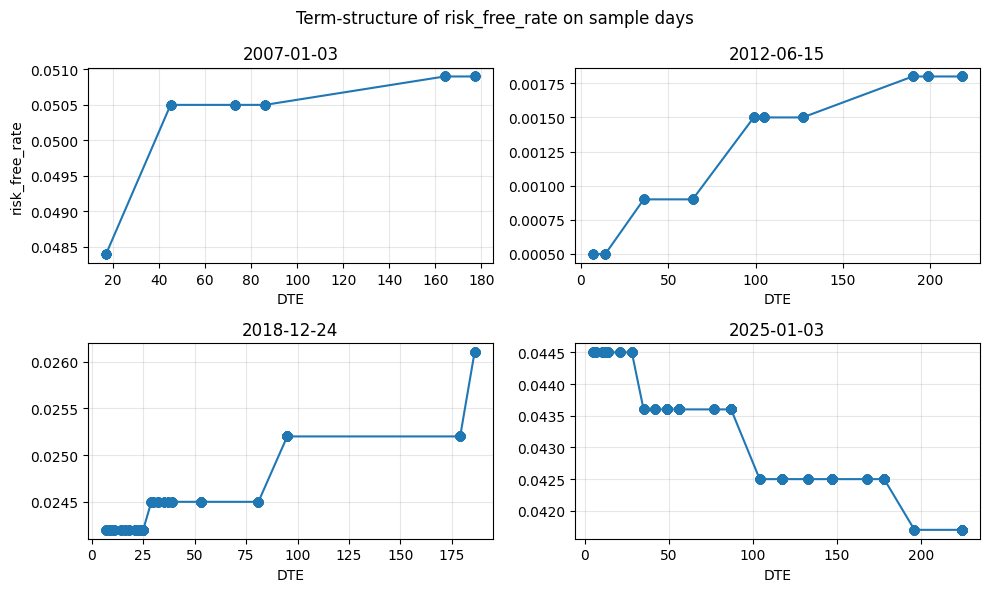

In [45]:
sample_days = [
    date(2007, 1, 3),
    date(2012, 6, 15),
    date(2018, 12, 24),
    date(2025, 1, 3),
]

plot_term_structure_samples(df, sample_days=sample_days, value_col="risk_free_rate")

The step-like profile is consistent with ORATS using a small set of tenor
anchors (piecewise term-structure) rather than a fully free curve at every DTE.
Across sample days, levels shift with macro regimes while preserving coherent
monotone/near-monotone shape by maturity.

# **11. Implied Volatility Quality Checks**

We split IV diagnostics into one HARD validity check and two SOFT tail checks.

- `iv_non_negative` is a **HARD** check: implied volatility should never be
  negative in clean data.

- `GLOBAL_high_iv` uses a **100% IV threshold** (`smoothed_iv > 1.0`).
  This can occur during extreme stress regimes (for example, crisis windows).

- `GLOBAL_very_high_iv` uses a **200% IV threshold** (`smoothed_iv > 2.0`).
  This is much stricter and should be rare.


In [46]:
iv_checks = qc_helpers.qc_table(
    [
        "iv_non_negative",
        "GLOBAL_high_iv",
        "GLOBAL_very_high_iv",
    ]
)
iv_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""iv_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_high_iv""","""SOFT""","""OK""",true,15073890,null,9378,0.000622
"""GLOBAL_very_high_iv""","""SOFT""","""OK""",true,15073890,null,0,0.0


In [47]:
qc_helpers.info_stats_metric("GLOBAL_core_numeric_stats", "smoothed_iv")

,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,smoothed_iv,0.0,15073890,0.01,1.95156,0.206395,0.098493,0.188129,0.01,0.072138,0.092514,0.188129,0.378108,0.520645,1.95156


## Smile Shapes

We use **delta** as the moneyness measure so that calls and puts can be placed on a
single, continuous implied-volatility curve.

ORATS provides a **smoothed implied-volatility surface** (SMV) that is shared across
calls and puts. This lets us analyse the smile consistently across option types and
maturities (e.g., 10, 30, and 60 DTE).

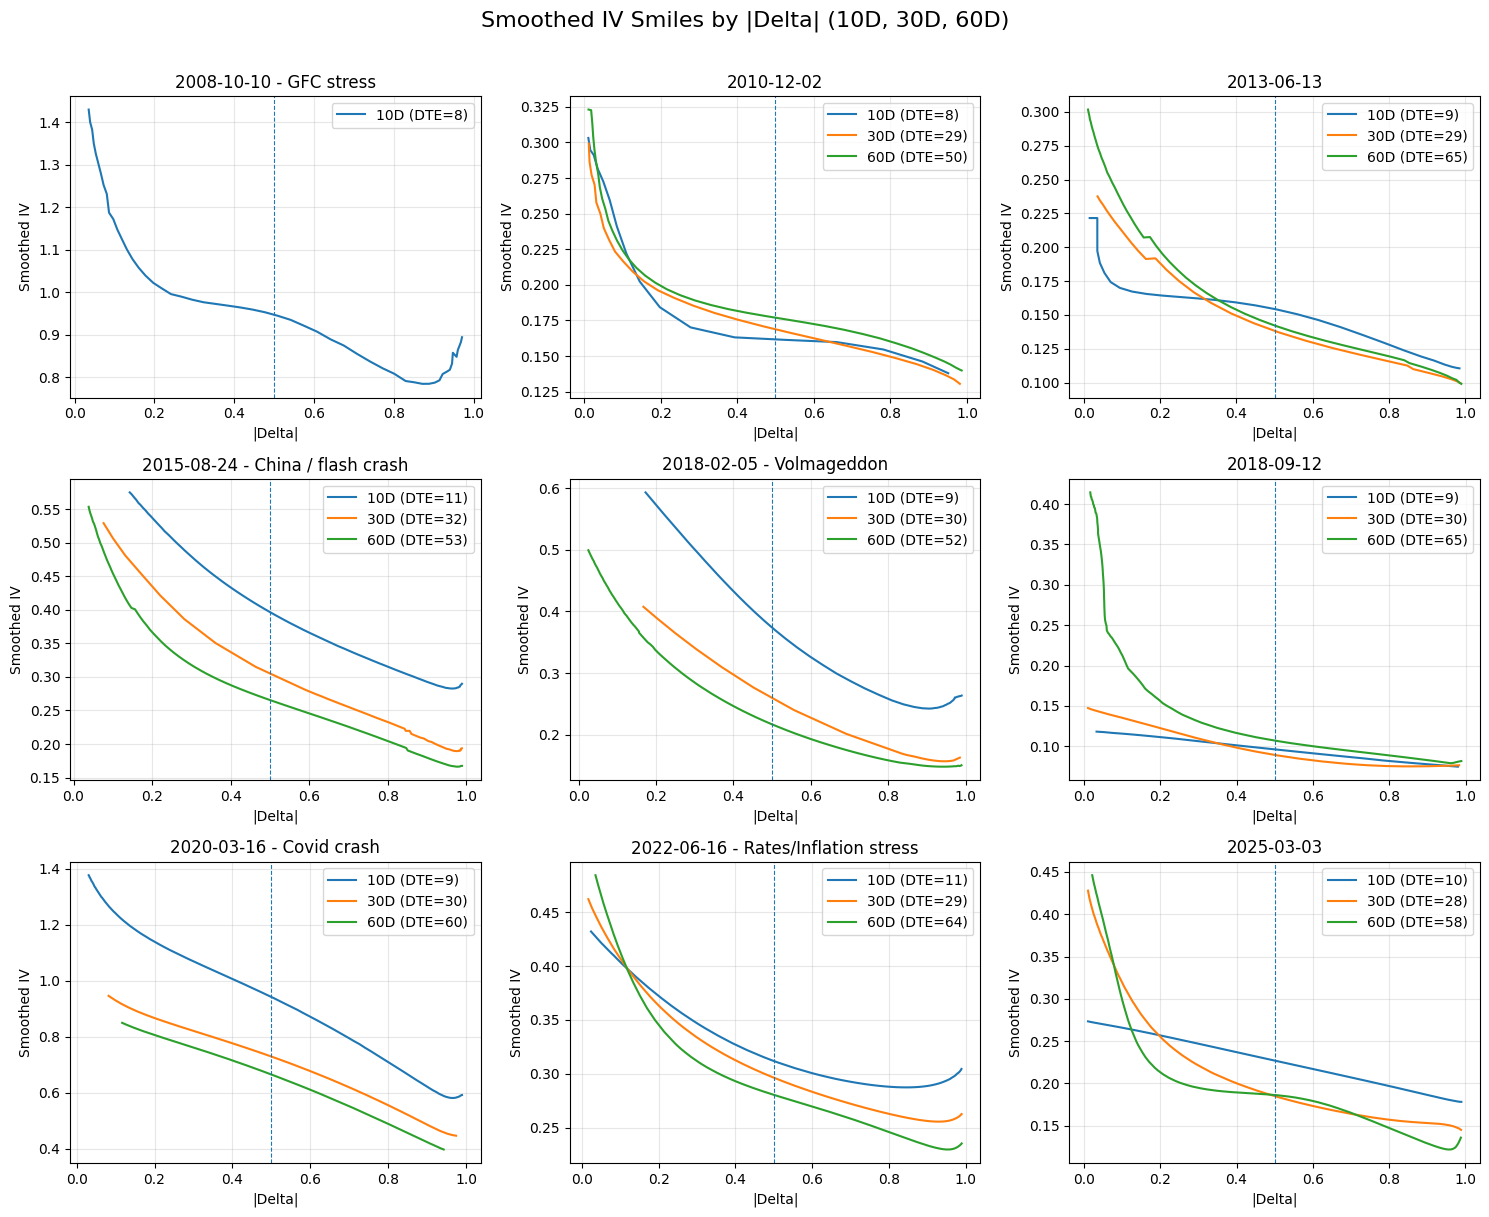

In [48]:
picked_dates = [
    date(2008, 10, 10),
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2015, 8, 24),  
    date(2018, 2, 5),  
    date(2018, 9, 12),
    date(2020, 3, 16), 
    date(2022, 6, 16), 
    date(2025, 3, 3),
]

event_labels = {
    date(2008, 10, 10): "GFC stress",
    date(2015, 8, 24): "China / flash crash",
    date(2018, 2, 5): "Volmageddon",
    date(2020, 3, 16): "Covid crash",
    date(2022, 6, 16): "Rates/Inflation stress",
}

plot_smiles_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

Because the **IV values we plot are already SMV-smoothed**, we do not apply any
additional smoothing. A simple interpolation across reported points is sufficient
when we want to visualise a continuous curve. In practice, if we need IV at a
specific target (e.g., a strike or delta bucket), we either:
- **select the closest available quote** (nearest neighbour), or
- **linearly interpolate** between adjacent quotes (if the target lies between them).

For details on the ORATS smoothing methodology (SMV system), see:
https://orats.com/blog/smoothing-options-implied-volatilities-using-orats-smv-system

## Term-Structure Shapes

This figure plots **implied-volatility term structures** (Smoothed IV vs **DTE**) for a few **delta buckets**
across multiple **trade dates** (one facet per date).

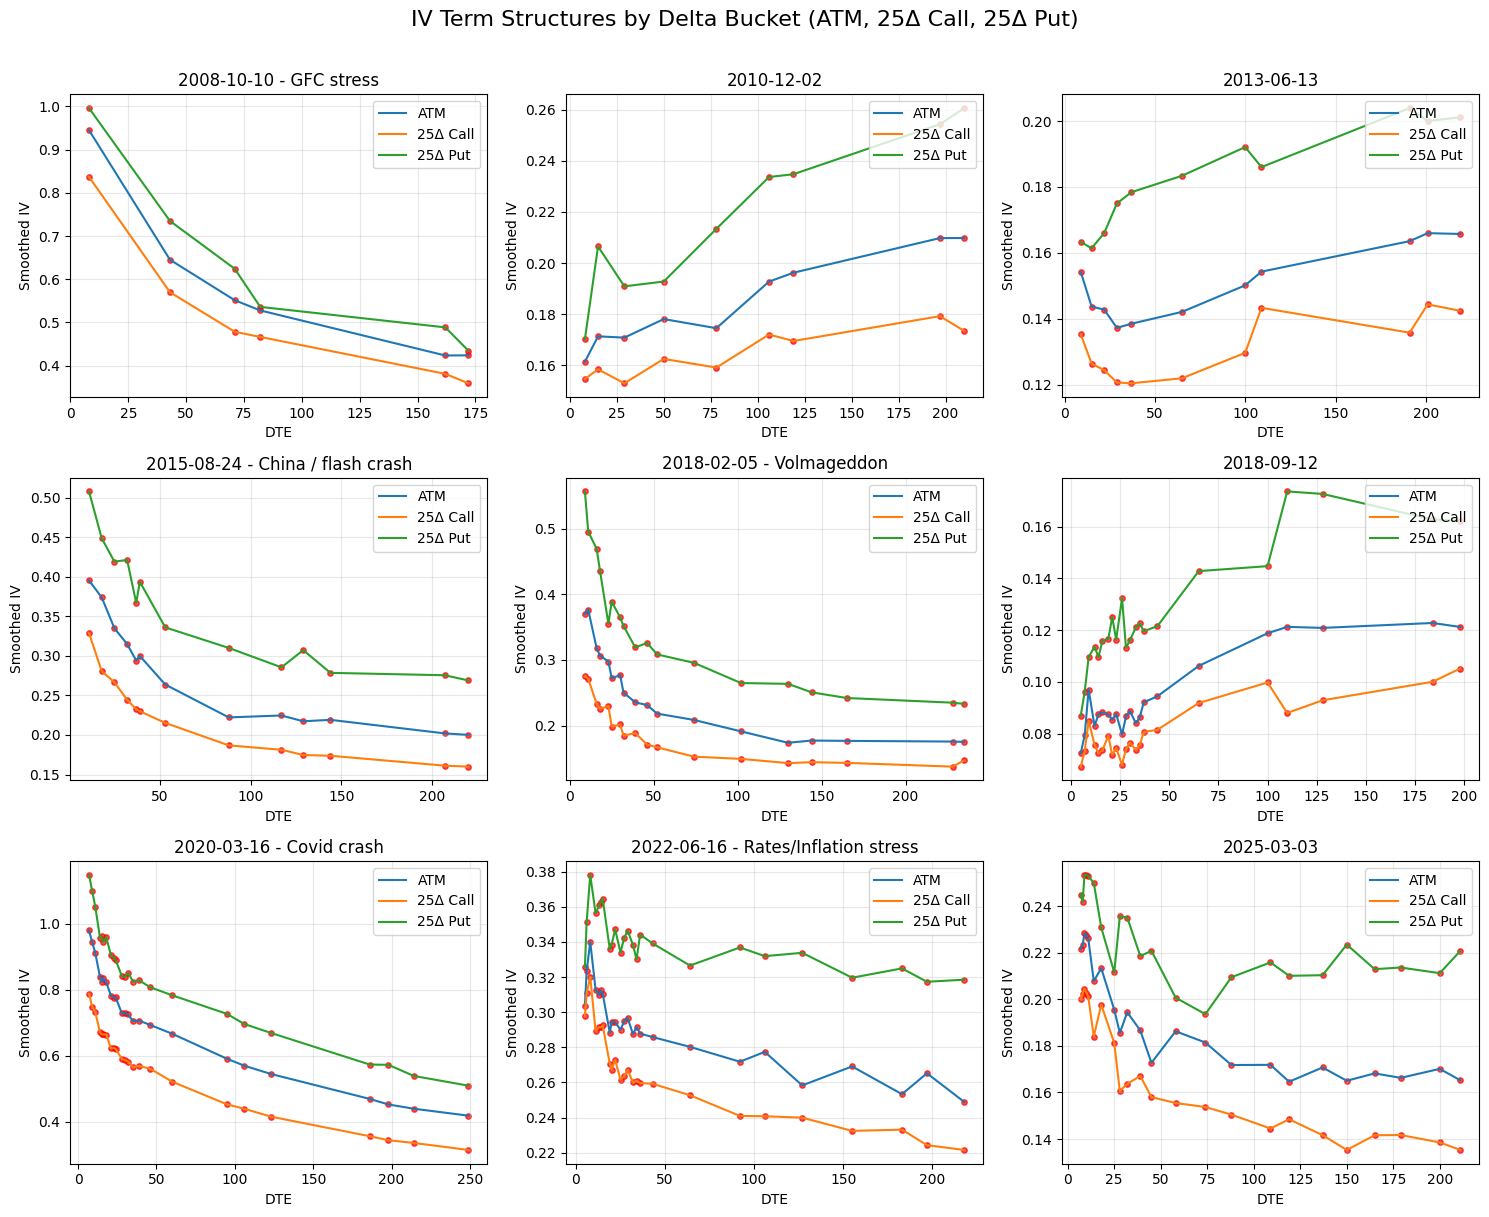

In [49]:
plot_term_structures_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

On **crash / stress dates**, the term structure often becomes **inverted (backwardation)**: short-dated IV rises
relative to longer-dated IV. In more **normal regimes**, it is typically **upward sloping (contango)**, with
longer-dated IV above short-dated IV.

## Implied Volatility Time-Series

The figure shows the evolution of smoothed implied volatility over time for
multiple maturities (e.g., 10D, 30D, 90D, 1Y).

Each series reflects the market’s forward-looking risk expectations over a
different horizon:
- short-dated IV (10–30D) captures **near-term uncertainty**
- medium maturities (90D) reflect **quarterly risk**
- long-dated IV (1Y) embeds **structural / long-run expectations**

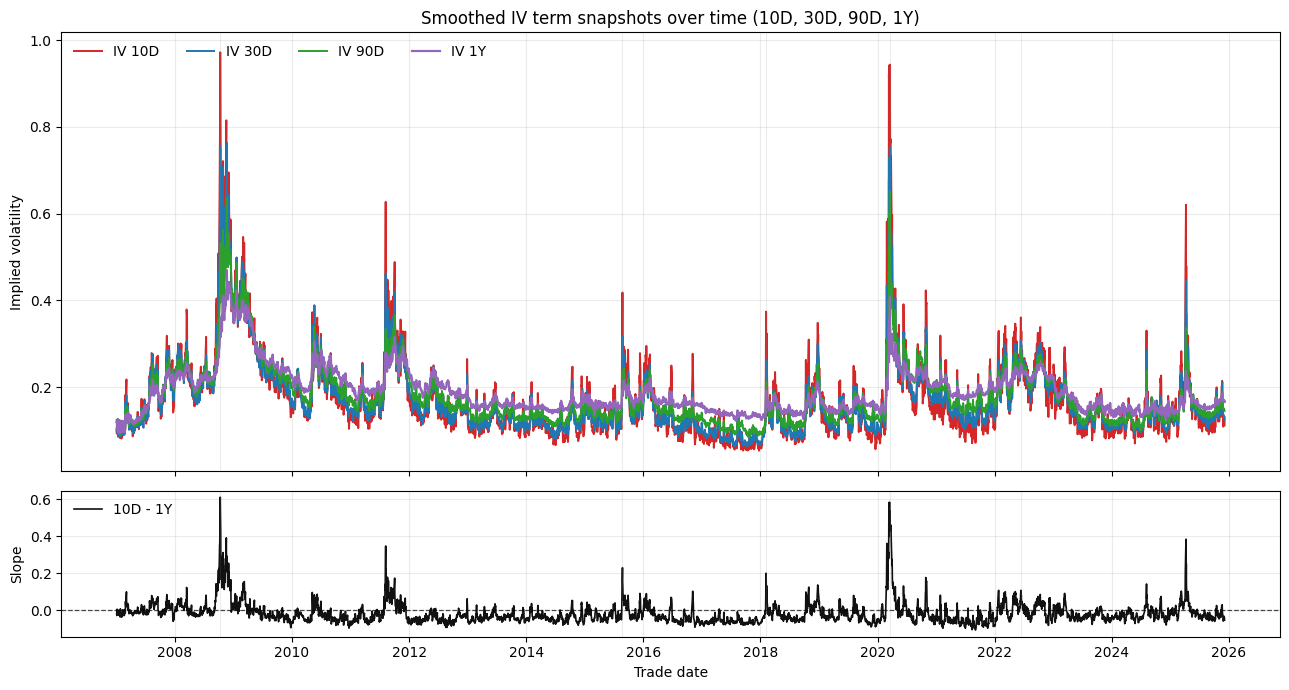

In [50]:
plot_iv_time_series_with_slope(daily_features, event_labels=event_labels)

Short-dated IV is more reactive than longer maturities, especially during crises,
as markets price immediate uncertainty over the next weeks.

Longer maturities (e.g., 1Y) also rise but more smoothly since they embed
expectations over a full year, including the anticipated post-shock recovery.

The lower panel (`10D - 1Y`) is a compact slope diagnostic:
- positive values indicate short-dated stress dominance (backwardation),
- negative values indicate a more normal contango-like term shape.

# **12. Greeks Sanity Checks**

We split Greeks QC into HARD data errors and SOFT diagnostics.

1. **HARD sign errors (drop-candidate rows)**
   - `gamma_non_negative`
   - `vega_non_negative`
   These are treated as structural issues in a clean options chain.
   In the pipeline they are HARD checks with a tiny numeric tolerance:
   violation if `gamma < -1e-8` or `vega < -1e-8`.

2. **SOFT diagnostics (investigate rate and location first)**
   - `*_delta_bounds_sane_*` for calls/puts, GLOBAL and ROI
   - `*_theta_positive_*` for calls/puts, GLOBAL and ROI

   Delta theoretical bounds are:
   $$
   0 \le \Delta_C \le 1,\qquad -1 \le \Delta_P \le 0.
   $$
   We still allow small numeric noise at row level (`eps=1e-5`), then judge
   the **violation rate** with soft thresholds.

   Positive theta is also SOFT (row tolerance `eps=1e-8`) because it can be
   legitimate in some cases, for example:
   - dividend/carry effects (especially American options),
   - deep ITM contracts with early-exercise effects,
   - very short-maturity edge cases and vendor-Greeks approximation noise.

In [51]:
greeks_checks_cols = [
    "gamma_non_negative",
    "vega_non_negative",
    "GLOBAL_delta_bounds_sane_C",
    "GLOBAL_delta_bounds_sane_P",
    "ROI_delta_bounds_sane_C",
    "ROI_delta_bounds_sane_P",
    "GLOBAL_theta_positive_C",
    "GLOBAL_theta_positive_P",
    "ROI_theta_positive_C",
    "ROI_theta_positive_P",
]

qc_helpers.qc_table(greeks_checks_cols)

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""gamma_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""vega_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_delta_bounds_sane_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_delta_bounds_sane_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_theta_positive_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_theta_positive_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""ROI_delta_bounds_sane_C""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_delta_bounds_sane_P""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_theta_positive_C""","""SOFT""","""OK""",true,2678530,null,0,0.0


In [52]:
qc_helpers.qc_thresholds(greeks_checks_cols)

name,mild,warn,fail
str,f64,f64,f64
"""GLOBAL_delta_bounds_sane_C""",0.000001,0.00001,0.0001
"""GLOBAL_delta_bounds_sane_P""",0.000001,0.00001,0.0001
"""GLOBAL_theta_positive_C""",0.001,0.005,0.01
"""GLOBAL_theta_positive_P""",0.001,0.005,0.01
"""ROI_delta_bounds_sane_C""",0.000001,0.00001,0.0001
"""ROI_delta_bounds_sane_P""",0.000001,0.00001,0.0001
"""ROI_theta_positive_C""",0.001,0.005,0.01
"""ROI_theta_positive_P""",0.001,0.005,0.01


## Greeks vs Strike

Here we investigate how option Greeks vary with strike for both calls and puts,
highlighting the typical theoretical shapes observed around the ATM region and
in the wings.

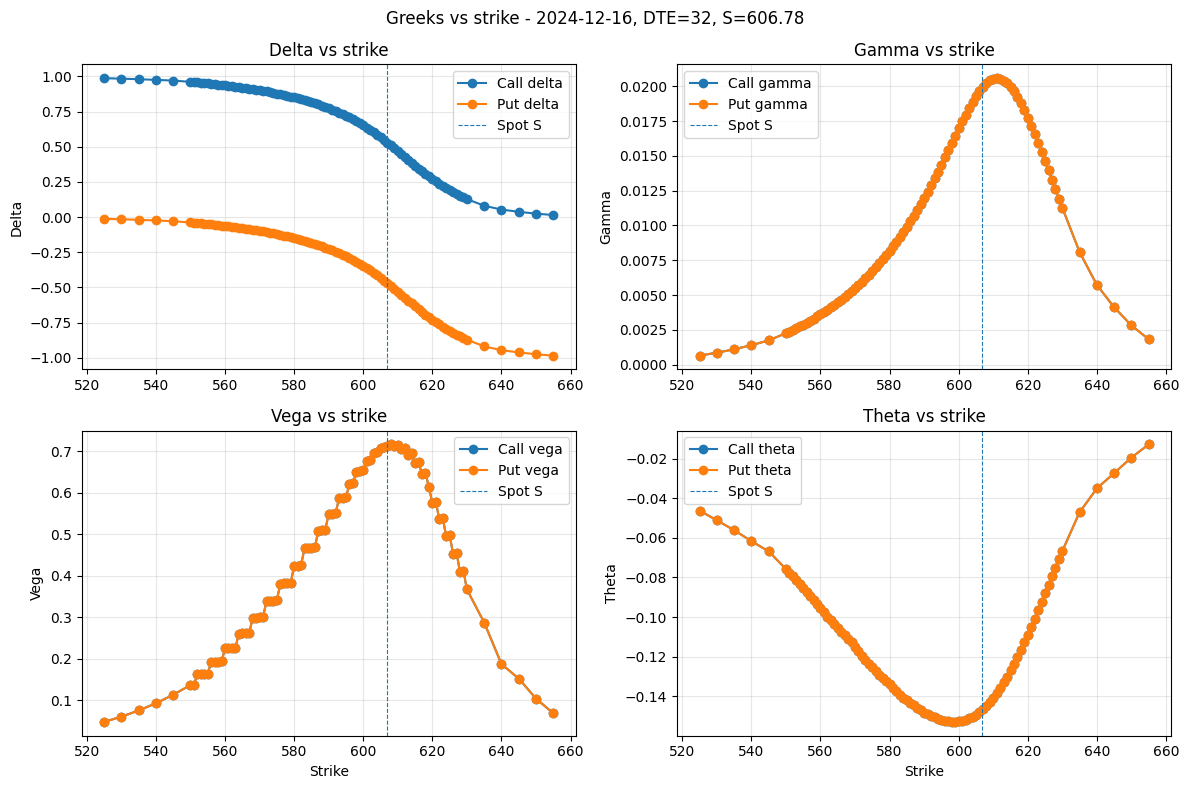

In [53]:
day = date(2024, 12, 16)
dte_target = 30

plot_greeks_vs_strike(df_long, day=day, dte_target=dte_target)

- **Delta** should be monotonic in strike: from near `+1` (deep ITM calls) toward
  `0` (deep OTM calls). For puts, delta typically lies in `[-1, 0]` under the
  standard sign convention.
- **Gamma** and **Vega** usually peak near ATM and decay in the wings.
- **Theta** is typically negative for long options near ATM, though localized
  positive-theta pockets can appear (carry/dividend effects and, for American
  options, early-exercise features).

**Note on ORATS conventions:** ORATS uses a consistent convention for quoting
Greeks across calls and puts (e.g., shared formulations and sign conventions).
When comparing call/put surfaces, interpret values according to this convention.
See: [ORATS – “Option Greeks are the same for calls and puts”](https://orats.com/blog/option-greeks-are-the-same-for-calls-and-puts).

# **13. Put-call parity diagnostics**

### Economic context (AOA)

In frictionless markets, no-arbitrage implies a strict parity relation for
European options:

$$
C_E - P_E = S_0 e^{-qT} - K e^{-rT}.
$$

### Tradable arbitrage context

In live markets, we cannot trade at mid and we pay bid/ask costs. So a small
parity gap is often non-actionable. We therefore assess parity with a
spread-aware tolerance rather than as an exact equality.

### American parity check used in this QC

SPY options are American, so we use bounds (not equality):

$$
S_0 e^{-qT} - K \le C_A - P_A \le S_0 - K e^{-rT}.
$$

Using mid prices:

$$
L = C_{\text{mid}} - P_{\text{mid}}.
$$

Dynamic tolerance:

$$
\tau = \alpha\Big((C_{\text{ask}}-C_{\text{bid}}) + (P_{\text{ask}}-P_{\text{bid}})\Big) + \tau_0.
$$

In this pipeline, $\alpha = 1.0$ and $\tau_0 = 0.01$.
We flag a violation when:

$$
L < \text{lower} - \tau \quad \text{or} \quad L > \text{upper} + \tau.
$$

This is a SOFT data-quality diagnostic: high violations in ROI are more
concerning than violations concentrated in illiquid wings.

In [54]:
pcp_checks_cols = [
    "GLOBAL_pcp_bounds_mid_am",
    "ROI_pcp_bounds_mid_am",
]

qc_helpers.qc_table(pcp_checks_cols)

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_pcp_bounds_mid_am""","""SOFT""","""OK""",true,7530569,null,317965,0.042223
"""ROI_pcp_bounds_mid_am""","""SOFT""","""MILD""",true,1339261,null,125691,0.093851


In [55]:
qc_helpers.qc_top_buckets(pcp_checks_cols[0])

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(0.3, 0.7]""",14886,110331,0.134921,0.046816,0.014651
"""(30, 60]""","""(0.7, 0.9]""",30014,233861,0.128341,0.094394,0.031055
"""(30, 60]""","""(0.3, 0.7]""",26028,242655,0.107263,0.081858,0.032223
"""(10, 30]""","""(0.3, 0.7]""",28947,275071,0.105235,0.091038,0.036527
"""(10, 30]""","""(0.7, 0.9]""",29049,285256,0.101835,0.091359,0.03788


In [56]:
qc_helpers.qc_top_buckets(pcp_checks_cols[1])

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(0.3, 0.7]""",2204,13349,0.165106,0.017535,0.009967
"""(0, 10]""","""(0.7, 0.9]""",1985,14087,0.14091,0.015793,0.010518
"""(30, 60]""","""(0.7, 0.9]""",30014,233854,0.128345,0.238792,0.174614
"""(30, 60]""","""(0.3, 0.7]""",26028,242655,0.107263,0.207079,0.181186
"""(10, 30]""","""(0.3, 0.7]""",28947,275071,0.105235,0.230303,0.20539


A meaningful share of parity violations appears in the `(0.3, 0.7]` delta
bucket, which is closer to the tradable region than far-wing-only issues.

However, this parity check is highly sensitive to the dividend-yield input
(`q`). Because dividend-yield behavior is unstable near some expiries, parity
alerts should be interpreted jointly with dividend diagnostics before acting.

# **14. Price-bounds diagnostics (calls and puts)**

We monitor two no-arbitrage envelopes and treat violations as SOFT diagnostics.

### American-spot bounds

Spot-based bounds used as an additional diagnostic:

$$
\max(0, S_0-K) \le C_{\text{mid}} \le S_0,
$$
$$
\max(0, K-S_0) \le P_{\text{mid}} \le K.
$$


Bounds are evaluated with spread-aware tolerance:

$$
\tau=\max\!\big(\tau_0,\alpha\,|\text{ask}-\text{bid}|\big),
$$

with $\alpha=1.0$ and $\tau_0=0.01$ in this pipeline.
A row is flagged when:

$$
\text{mid} < \text{lower} - \tau \quad \text{or} \quad \text{mid} > \text{upper} + \tau.
$$

Interpretation: small rates outside ROI can be microstructure noise; persistent
ROI violations are more concerning for tradable strategies.

In [57]:
bounds_checks = qc_helpers.qc_table(
    [
        "GLOBAL_price_bounds_mid_am_C",
        "GLOBAL_price_bounds_mid_am_P",
        "ROI_price_bounds_mid_am_C",
        "ROI_price_bounds_mid_am_P",
    ]
)
bounds_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_price_bounds_mid_am_C""","""SOFT""","""FAIL""",false,15073890,null,4095403,0.271689
"""GLOBAL_price_bounds_mid_am_P""","""SOFT""","""WARN""",false,15073890,null,2678940,0.177721
"""ROI_price_bounds_mid_am_C""","""SOFT""","""FAIL""",false,2678530,null,654689,0.244421
"""ROI_price_bounds_mid_am_P""","""SOFT""","""WARN""",false,2678530,null,394119,0.14714


A **large number of price-bound violations** is observed across calls, puts, and the tradeable ROI. To localise the issue, we analyse breaches using **DTE × delta buckets**.

In [58]:
qc_helpers.qc_top_buckets("ROI_price_bounds_mid_am_C")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.1, 0.3]""",233850,352106,0.664147,0.357192,0.131455
"""(10, 30]""","""(0.1, 0.3]""",285249,434352,0.656723,0.435702,0.162161
"""(0, 10]""","""(0.1, 0.3]""",14087,21728,0.648334,0.021517,0.008112
"""(10, 30]""","""(0.3, 0.7]""",64525,550143,0.117288,0.098558,0.20539
"""(0, 10]""","""(0.3, 0.7]""",3083,26698,0.115477,0.004709,0.009967


In [59]:
qc_helpers.qc_top_buckets("ROI_price_bounds_mid_am_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(0.1, 0.3]""",7641,21728,0.351666,0.019388,0.008112
"""(10, 30]""","""(0.1, 0.3]""",149097,434352,0.343263,0.378305,0.162161
"""(30, 60]""","""(0.1, 0.3]""",118243,352106,0.335816,0.300019,0.131455
"""(0, 10]""","""(0.3, 0.7]""",3097,26698,0.116001,0.007858,0.009967
"""(30, 60]""","""(0.3, 0.7]""",54758,485311,0.112831,0.138938,0.181186


- Violations are **heavily concentrated in low-delta wings**, particularly in the **(0.1, 0.3] bucket** across short and medium maturities, where **rates exceed ~65%**.

- By contrast, the **(0.3, 0.7] region (near-ATM, more tradeable)** shows **much lower violation rates** and a **smaller share of total breaches**.

Overall, **global violation metrics overstate the practical impact**: most inconsistencies arise in **far-OTM, lower-liquidity regions**, not in the **core tradable surface**.

# **15. Monotonicity diagnostics**

We treat monotonicity checks as SOFT diagnostics and separate them into strike-
based and maturity-based arbitrage interpretations.

## 15.1. Vertical spread arbitrage (strike monotonicity)

For fixed trade date and expiry, strike monotonicity conditions are:

$$
C(K_1, T) \ge C(K_2, T) \quad \text{for } K_1 < K_2,
$$
$$
P(K_1, T) \le P(K_2, T) \quad \text{for } K_1 < K_2.
$$

In practice (American exercise + quote noise), we treat violations as SOFT and
judge impact using GLOBAL vs ROI concentration.

In [60]:
strike_monotonicity_checks = qc_helpers.qc_table(
    [
        "GLOBAL_strike_monotonicity_C",
        "GLOBAL_strike_monotonicity_P",
        "ROI_strike_monotonicity_C",
        "ROI_strike_monotonicity_P",
    ]
)
strike_monotonicity_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_strike_monotonicity_C""","""SOFT""","""OK""",true,15073890,null,17039,0.00113
"""GLOBAL_strike_monotonicity_P""","""SOFT""","""OK""",true,15073890,null,13667,0.000907
"""ROI_strike_monotonicity_C""","""SOFT""","""OK""",true,2678530,null,256,0.000096
"""ROI_strike_monotonicity_P""","""SOFT""","""OK""",true,2678530,null,411,0.000153


In [61]:
qc_helpers.qc_top_buckets("GLOBAL_strike_monotonicity_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(-inf, 0]""",1786,111212,0.016059,0.13068,0.014756
"""(0, 10]""","""(-inf, 0]""",4538,310018,0.014638,0.332041,0.041133
"""(30, 60]""","""(-inf, 0]""",171,21540,0.007939,0.012512,0.002858
"""(0, 10]""","""(0, 0.05]""",2333,386997,0.006028,0.170703,0.051347
"""(10, 30]""","""(0, 0.05]""",2130,393513,0.005413,0.15585,0.052211


All strike-monotonicity checks show a **very small violation rate**, and most
violations are concentrated in the wings, which limits tradability impact.

## 15.2. Calendar arbitrage (maturity monotonicity)

At fixed strike, maturity monotonicity is:

$$
C(K, T_2) \ge C(K, T_1), \qquad P(K, T_2) \ge P(K, T_1)
\quad \text{for } T_2 > T_1.
$$

We monitor maturity-order violations as SOFT diagnostics, with emphasis on ROI
where tradability impact is highest.

In [62]:
maturity_monotonicity_checks = qc_helpers.qc_table(
    [
        "GLOBAL_maturity_monotonicity_C",
        "GLOBAL_maturity_monotonicity_P",
        "ROI_maturity_monotonicity_C",
        "ROI_maturity_monotonicity_P",
    ]
)
maturity_monotonicity_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_maturity_monotonicity_C""","""SOFT""","""OK""",true,15073890,null,126491,0.008391
"""GLOBAL_maturity_monotonicity_P""","""SOFT""","""MILD""",true,15073890,null,351111,0.023293
"""ROI_maturity_monotonicity_C""","""SOFT""","""OK""",true,2678530,null,1750,0.000653
"""ROI_maturity_monotonicity_P""","""SOFT""","""OK""",true,2678530,null,2917,0.001089


The violation rate is low (less than 2%) across all the checks except the `GLOBAL_maturity_monotonicity_P`. Thus we inspect the location of those violations usign the **Delta x Dte buckets**

In [63]:
qc_helpers.qc_top_buckets("GLOBAL_maturity_monotonicity_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(0.95, 1]""",107155,428723,0.24994,0.305188,0.056883
"""(0, 10]""","""(0.95, 1]""",108660,459052,0.236705,0.309475,0.060907
"""(30, 60]""","""(0.95, 1]""",49471,231335,0.21385,0.140898,0.030693
"""(60, 180]""","""(0.95, 1]""",49639,278094,0.178497,0.141377,0.036897
"""(180, inf]""","""(0.95, 1]""",6371,56771,0.112223,0.018145,0.007532


More than **50%** of maturity-monotonicity violations are located in very
extreme wings, so practical impact on the core tradable surface is limited.

## **16. Conclusion**

Overall, the **quality checks pass satisfactorily**, with most violations concentrated in the **far-OTM wings**, where liquidity is lower and quotes are inherently noisier.

For the **arbitrage checks**, the remaining breaches are **not treated as critical**. The ORATS option chains are generally regarded as **high-quality**, and these discrepancies are more likely attributable to **limitations in the specification of the checks for American options** (despite incorporating American put–call inequalities and theoretical bounds) rather than to genuine pricing inconsistencies.